Example 2: Analysis of a resonator from W63
======================

**By: Faustin Carter, 2016**

This notebook imports the data from the Agilent files, creates resonator objects from each datafile, packs those objects into a list, runs a semi-intelligent fitting algorithm predicated on the fact that things don't change too much from one temperature to the next, and then plots the data and fit curves in a nice way.

Once you've understood this example, you should be able to replicate it with your own data simply be writing a custom process_file function and updating the code that finds the datafiles.


Note: Before starting this example, you'll want to read up on list comprehensions and Python's built-in `map` method if you aren't already familiar with them.

In [1]:
#import all the necessary libraries

#For inline notebook figures
%matplotlib inline

#For high-res figures
%config InlineBackend.figure_format = 'retina' 
import glob #For easy file grabbing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs #For plot arrangement
import seaborn as sns #For pretty plots

#Some code to make plots pretty
sns.set_context("poster") #This makes all the text bigger automatically
sns.set_style("ticks",{"xtick.direction" : u"in","ytick.direction" : u"in"})

Load up the `pyRes` modules
----------
You'll need to change the path to reflect wherever you stored the code

In [2]:
#Change directories up one level since for some reason Jupyter can't handle importing submodules
#that are in the current directory. This is really on necessary if you want to run the notebook
#from within the directory.
import os
os.chdir('..')

#Add the current directory you are in to the path since that's where the pyRes module is currently living
import sys
sys.path.append(os.getcwd())

#Load up the resonator class code

#This is the main workhorse code here
from pyRes import Resonator, makeResFromData, lmfitRes

#Pre-packaged complex S21 fitting function with quadratic baseline removal
from pyRes.fitsS21 import IQcircle

#Some code to help deal with lists of resonator objects
from pyRes.containers import indexResList

#A routine to convert text files to data!
from pyRes import process_file

Load files and process data
----
This unpacks the file data into dict objects. This block of code is the only thing you need to change to make this work with your data.

In [3]:
#Load in list of files to plot
dataPath = './pyRes/ExampleData/'

#Define a resonator name. The data folder has data for RES-1, RES-2, RES-3, RES-4 so any of those will work.
#Try changing the name to one of the others and rerun the notebook.
resName = 'RES-1'

#grab files for this resonator
fileList = glob.glob(dataPath + '*' + resName + '_*' + '*')

#loop through files and process all the data
fileDataDicts = map(process_file, fileList)

#Strip out any bad files
fileDataDicts = [fileDataDict for fileDataDict in fileDataDicts if (fileDataDict is not None)]

Make a list of Resonator objects
-----------
Lists are a great way to organize things. `pyRes` includes a tool for easily indexing lists of Resonator objects by temperature and power. Each object has a value called `itemp` that is just the experiment temperature rounded to the nearest 5 mK. This helps a lot with organizing data taken at the 'same' temperature that has fluctuations.

In [4]:
#Create resonator objects from the data
#This uses pyRes's built-in makeResFromData tool
resObjsTuple = [makeResFromData(fileDataDict) for fileDataDict in fileDataDicts]

#Pack the resulting resonator objects in to a list of resonator objects
resList, itemps, pwrs = map(list, zip(*resObjsTuple))

#Create index vectors for all temps and pwrs in the experiment

#itemp = temp rounded to the nearest 5 mK
itempsList = np.unique(itemps)
pwrsList = np.unique(pwrs)

#Let's look at all the temperatures and powers in the experiment
print 'number of resonators in list = ', len(resList)
print 'temps = ', itempsList
print 'powers = ', pwrsList      
print 'temps x powers = ', len(itempsList)*len(pwrsList)

#Can you figure out why the number of resonators in resList is different from temps*powers?
#Hint: look in the data folder at the names of the data files and compare temperatures.

#This difference is why it is always important to check and make sure the Resonator object you ask for 'is not None'
#If you have a clever way to fix this issue, please tell me!

number of resonators in list =  278
temps =  [ 0.085  0.09   0.095  0.1    0.11   0.115  0.125  0.14   0.145  0.16
  0.175  0.195  0.215  0.235  0.25   0.26   0.265  0.27   0.31   0.34
  0.385  0.425  0.465  0.51   0.55   0.585  0.63   0.67   0.705  0.75
  0.785  0.79   0.83   0.87   0.915  0.955  0.995  1.     1.035  1.07
  1.105  1.145  1.185  1.19   1.225  1.23   1.265  1.34   1.345  1.415
  1.42   1.495  1.57   1.575  1.645  1.65   1.725  1.73   1.735  1.81
  1.815  1.89   1.895  1.975  2.035  2.04   2.045  2.11   2.115  2.12   2.18
  2.19   2.195  2.265  2.27   2.345  2.35   2.355  2.4    2.41   2.415
  2.47   2.475  2.48   2.485]
powers =  [-50. -40. -30. -20. -10.]
temps x powers =  425


Fit I and Q data to a model
--------------
This fits I and Q data simultaneously in a smart way. We assume that the lowest temperature data for any given power is the best, and use that as starting point. The best-fit values from that curve are then applied as guesses for the next temperature, and then the best fit values from that are used for the next, etc.

In [5]:
#Loop through each power
for pwr in pwrsList:

    #Fit the lowest temp curve at each power, and use that to help guess parameters for the next curve.
    #The idea here is that the lowest temperature curve has the highest Q and the best signal to noise.
    #Since curves don't change much with temperature, each previous succesful fit is used as the guess for the next.
    for index, tval in enumerate(itempsList):

        #Grab the index of the first Resonator object using the indexResList tool
        resIndex = indexResList(resList, itempsList[index], pwr)
        if resIndex is not None:
            break #Quit the for loop as soon as we find the desired index

    #Grab the desired Resonator object from the list, and use the lmfitRes tool to run the fit
    res2fit = resList[resIndex]
    lmfitRes(res2fit, IQcircle)

    #If you want to set a custom value for qi or qc, use the code below instead of the line above
    #lmfitRes(res2fit, IQcircle, qi=1e5, qc=1e4)

    #Save the sucesful fit parameters so we can apply them to the next fit
    lastParams = res2fit.S21result.params

    #Loop through temperatures (except the first) and fit each S21 curve
    for itmp in itempsList[1:]:

        #Unpack the best fit values from the previous fit and use them as guesses
        qiGuess = lastParams['qi'].value
        qcGuess = lastParams['qc'].value
        dfGuess = lastParams['df'].value
        pg0Guess = lastParams['pgain0'].value

        #Apply those guesses and fit each Resonator object
        for res in resList:
            #Could use indexResList here, but this is more efficient, and avoids having to check for 'is not None'
            if res.itemp == itmp and res.pwr == pwr:
                #Fit the Resonator
                lmfitRes(res, IQcircle, qi=qiGuess, qc=qcGuess, df=dfGuess, pgain0=pg0Guess)
                
                #Update the parameters
                lastParams = res.S21result.params

Make a pretty plot
---------
Fits aren't worth anything if you don't plot the results!!

(-3, 3)

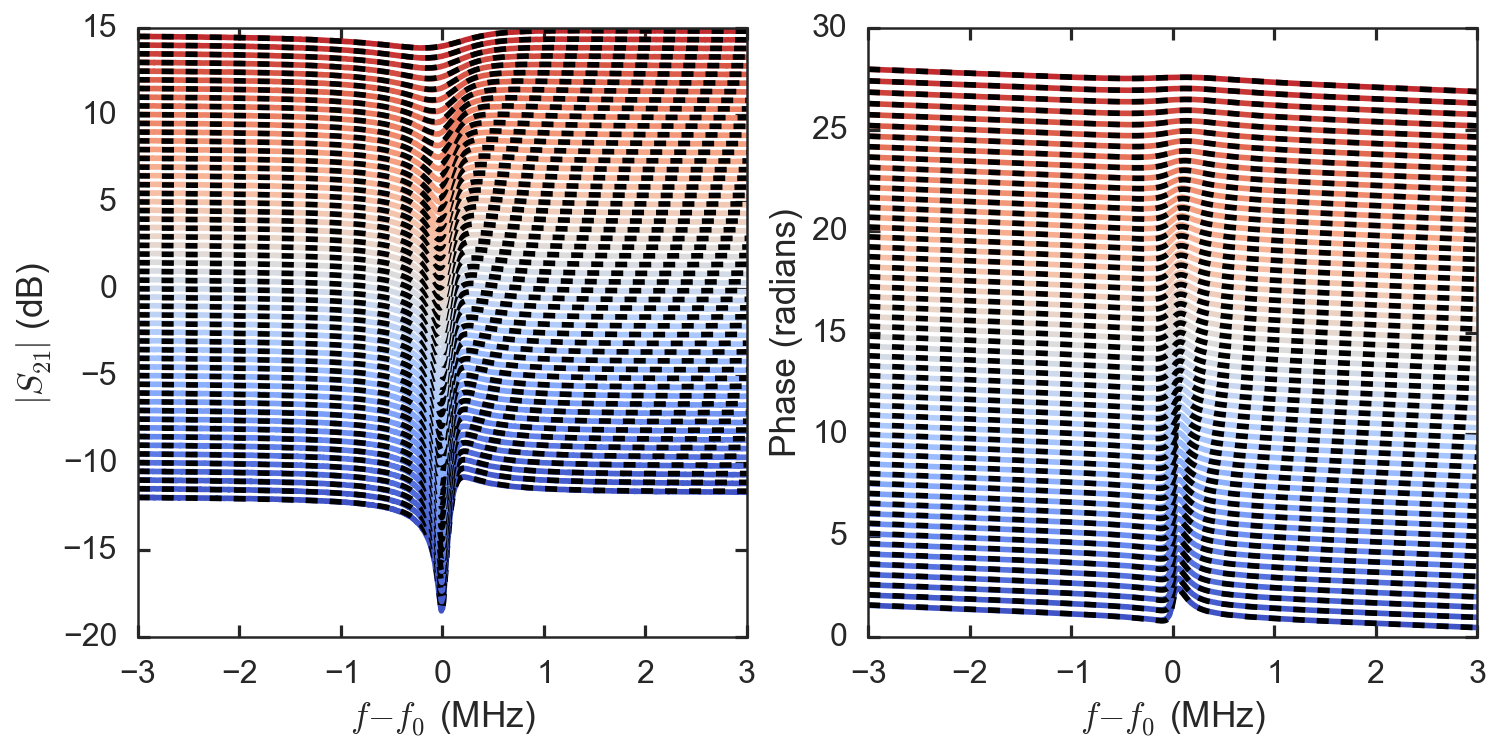

In [7]:
#Lets look at plots from a single power value. Change this to look at other plots
pval = -30

#Set up a figure to overlay the |S21| fits and data
figA = plt.figure()
figA.set_size_inches(12,12)
axMag = figA.add_subplot(221)
axPhase = figA.add_subplot(222)


#Make sure the colors look badass
numTraces = int(np.ceil(len(resList)/len(pwrsList))) #Always round up!
sns.set_palette(sns.color_palette("coolwarm", numTraces))

#Set an index for offsetting the traces in a fancy waterfall way
index2=0

#Loop through 
for index, tval in enumerate(itempsList):

    #grab the right resonator object from the list
    resIndex = indexResList(resList, tval, pval)

    if resIndex is not None:
        res = resList[resIndex]
        axMag.plot((res.freq-res.S21result.params['f0'].value)*1e-6,10*np.log10(res.mag)+index2/2.0)
        axMag.plot((res.freq-res.S21result.params['f0'].value)*1e-6,10*np.log10(res.resultMag)+index2/2.0, 'k--')
        
        axPhase.plot((res.freq-res.S21result.params['f0'].value)*1e-6,res.phase+index2/2.0)
        axPhase.plot((res.freq-res.S21result.params['f0'].value)*1e-6,res.resultPhase+index2/2.0, 'k--')
        
        #Stack the next one up just a little bit more
        index2+=1
        
axMag.set_xlabel('$f-f_0$ (MHz)')
axMag.set_ylabel('$|S_{21}|$ (dB)')

#Comment this out if you want to see the full curves
axMag.set_xlim(-3,3)

axPhase.set_xlabel('$f-f_0$ (MHz)')
axPhase.set_ylabel('Phase (radians)')

#Comment this out if you want to see the full curves
axPhase.set_xlim(-3,3)

In [ ]:
#Save that figure in the local directory. You worked hard for it!
figA.savefig('Mag-and-Phase-E2.png')

Exercise 2.1:
-----
Using this notebook as a guide, implement code that will extend this analysis to an arbitrary number of resonators, and display the data for resonators 2-4 along with the one you just did. Instead of starting with `resName='RES-1'`, start with `resNames=['RES-1', 'RES-2', 'RES-3', 'RES-4']` and have the program run through all the resonators in the list, outputting the final figures for each resonator dynamically. You could use '`for resName in resNames:`' and go from there, with a few slight modifications along the way.

Exercise 2.2:
-----
Use the `ResonatorSweep` container object to make a data structure from your list of `Resonator` objects (you'll need to import it from `pyResMC.containers`. Use this data to make a surface plot of resonant frequency as functions of temperature and power. In other words, the x-axis should be temperature, the y-axis should be power, and the color (or height, if you prefer) of each bin should correspond to the resonant frequency. You will likely want to read up a bit on `pandas` `DataFrame` objects, as the `ResonatorSweep` object is a dict of `DataFrame` objects.

Once you have made this plot, it should be trivial to extend it to get plots of $Q_i$, $Q_c$, $\chi^2$, etc...

Exercise 2.3:
-----
Use the `ResonatorSweep` object that you made in the last Excersize to make a plot of frequency shift vs. temperature for each power, and overlay those plots on the same axis.